In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import datetime

In [2]:
df = pd.read_csv('Total_weather_dataset_in_HCM.csv')
del df['Unnamed: 0']

In [3]:
winds = set(df['Wind'])
df_HCM_pie = df.Wind.value_counts()
df_HCM_pie.values


array([15555,  6613,  5974,  5840,  4904,  3990,  3606,  2770,  2636,
        2390,  2333,  2066,  1838,  1793,  1593,  1583,  1315,  1220,
          11], dtype=int64)

In [4]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df['Wind']=le.fit_transform(df['Wind'])
df

Time  Temperature  Dew Point  Humidity  Wind  Wind Speed  \
0      12:00 AM         77.0       68.0      74.0     5         9.0   
1      12:30 AM         77.0       68.0      74.0     5        12.0   
2       1:00 AM         77.0       68.0      74.0     5         9.0   
3       1:30 AM         77.0       68.0      74.0     5        12.0   
4       2:00 AM         75.0       68.0      78.0     5         8.0   
...         ...          ...        ...       ...   ...         ...   
68025   3:30 PM         90.0       75.0      62.0    11         5.0   
68026   4:00 PM         90.0       77.0      66.0    13         9.0   
68027   4:30 PM         88.0       77.0      70.0    10        10.0   
68028   5:00 PM         88.0       75.0      66.0    10         8.0   
68029   5:30 PM         86.0       77.0      74.0    10         7.0   

       Wind Gust  Pressure  Precip.       Condition        Date  \
0            0.0     29.85   0.0 in   Mostly Cloudy  2019-01-02   
1            0.0     29.85   0.0 in   Mostly Cloudy  2019-01-02   
2            0.0     29.85   0.0 in   Mostly Cloudy  2019-01-02   
3            0.0     29.82   0.0 in   Mostly Cloudy  2019-01-02   
4            0.0     29.82   0.0 in   Mostly Cloudy  2019-01-02   
...          ...       ...      ...             ...         ...   
68025        0.0     29.70   0.0 in   Mostly Cloudy  2022-11-29   
68026        0.0     29.70   0.0 in   Mostly Cloudy  2022-11-29   
68027        0.0     29.70   0.0 in   Partly Cloudy  2022-11-29   
68028        0.0     29.70   0.0 in   Partly Cloudy  2022-11-29   
68029        0.0     29.73   0.0 in   Partly Cloudy  2022-11-29   

                  DateTime  
0      2019-01-02 00:00:00  
1      2019-01-02 00:30:00  
2      2019-01-02 01:00:00  
3      2019-01-02 01:30:00  
4      2019-01-02 02:00:00  
...                    ...  
68025  2022-11-29 15:30:00  
68026  2022-11-29 16:00:00  
68027  2022-11-29 16:30:00  
68028  2022-11-29 17:00:00  
68029  2022-11-29 17:30:00  

[68030 rows x 12 columns]

In [5]:
for i in range(0, len(df['Temperature'])):
    df['Temperature'][i] = int(df['Temperature'][i][1:-3])
    df['Dew Point'][i] = int(df['Dew Point'][i][1:-3])
    df['Humidity'][i] = int(df['Humidity'][i][1:-2])
    df['Wind Speed'][i] = int(df['Wind Speed'][i][1:-4])
    df['Pressure'][i] = float(df['Pressure'][i][1:-3])
df

IndexError: invalid index to scalar variable.

In [6]:
df.to_csv('Total.csv')

In [7]:
from statsmodels.tsa.stattools import adfuller
results = adfuller(df.Temperature.dropna())
print('p-value: ', results[1])

p-value:  8.556333686001286e-29


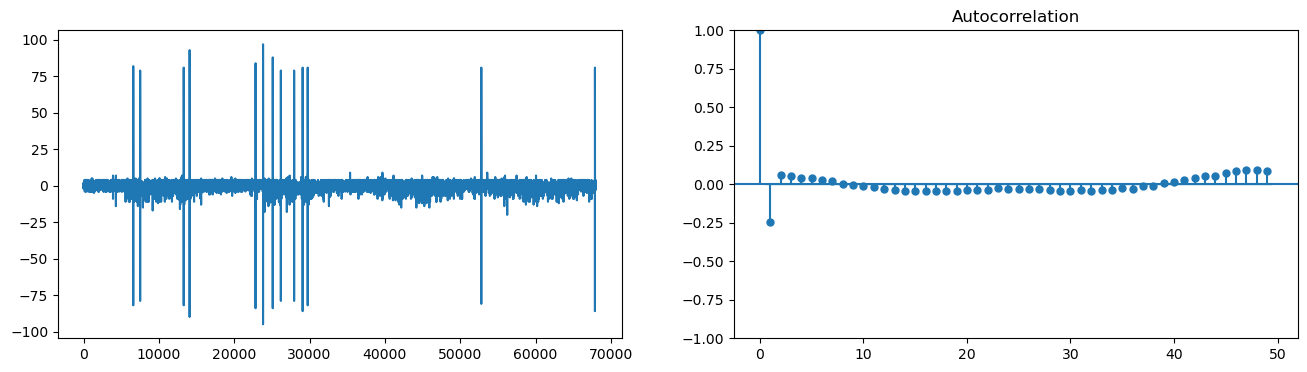

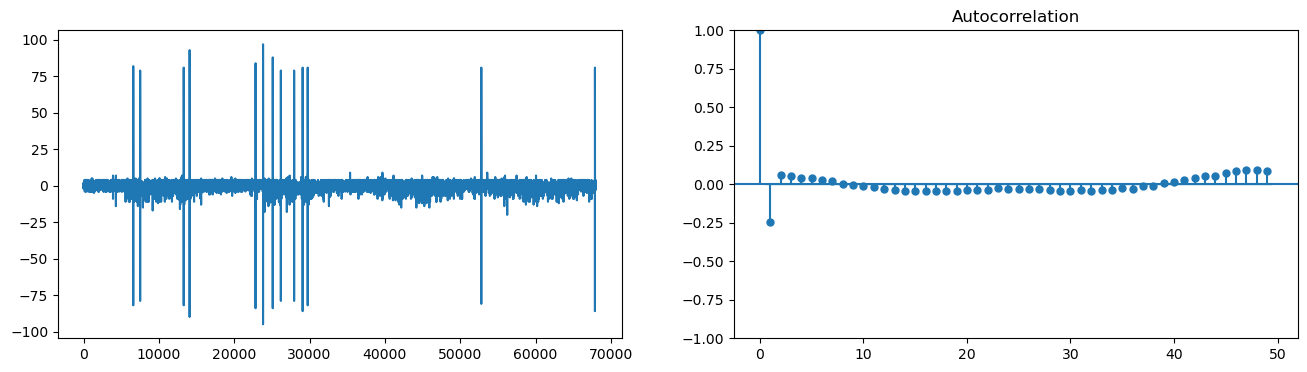

In [8]:
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(16,4))

diff = df.Temperature.diff().dropna()

ax1.plot(diff)
ax2.set_ylim(0,1)
plot_acf(diff, ax=ax2)
# plot_acf(diff, ax=ax2)

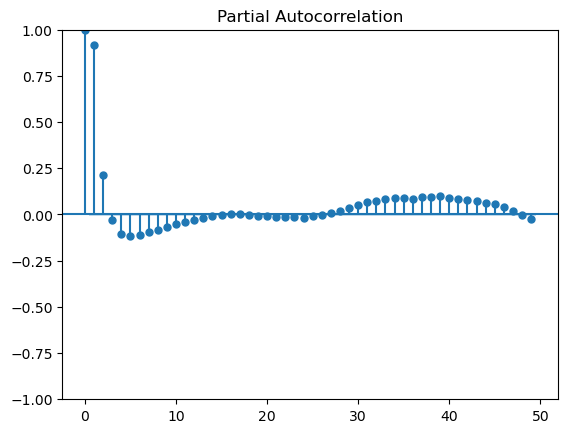

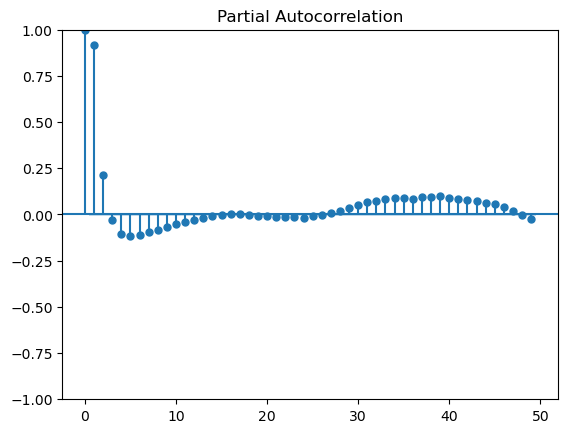

In [9]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_pacf(df.Temperature.dropna())

In [10]:
from pmdarima.arima import auto_arima
auto_arima(train['Humidity'])

ModuleNotFoundError: No module named 'pmdarima'

In [11]:
milestone = datetime.datetime(2022,10,1,00,00,00)
df2 = df.groupby(df.index).agg({'Humidity': 'max'}) 
train = df2.loc[df['DateTime'] > milestone].copy().iloc[::-1]
train = train.reset_index()
del train['index']
val = df2.loc[df['DateTime'] <= milestone].copy().iloc[::-1]
val = val.reset_index()
del val['index']

TypeError: '>' not supported between instances of 'str' and 'datetime.datetime'

In [12]:
train

NameError: name 'train' is not defined

In [13]:
from statsmodels.tsa.arima.model import ARIMA
# df2 = df.groupby(df.index).agg({'Temperature': 'max'}) 
milestone = datetime.datetime(2022,10,1,00,00,00)

def plot_arima_model(order=(0, 0, 0), 
                    seasonal_order=(0, 0, 0, 0), 
                    savefig=False):
    if seasonal_order == (0, 0, 0, 0):
        title = f'ARIMA{order} Predictions'
    else:
        title = f'SARIMA{order}{seasonal_order} Predictions' 
    arima  = ARIMA(train['Humidity'], order=order)
    result = arima.fit()

    # Predict len(val) timesteps into the future
    predictions = result.forecast(len(val['Humidity']))
    # predictions = result.predict(val)

    # Plot
    fig, ax = plt.subplots()
    ax.plot(df['Temperature'], 'b', label='Actual')
    ax.plot(predictions, 'r', label='Preds')
    ax.set(xlabel='DateTime', ylabel='Time',
            title=title)
    plt.legend()
    plt.tight_layout()
    if savefig:
        plt.savefig(title)
    plt.show()
    return predictions

# Plot ARIMA(1,1,1)
b = plot_arima_model(order=(2, 0, 2))
print(b)

NameError: name 'train' is not defined

In [14]:
milestone = datetime.datetime(2022,10,1,00,00,00)
train = df.loc[df.index < milestone].copy().iloc[::-1]
val = df.loc[df.index >= milestone].copy().iloc[::-1]

TypeError: '<' not supported between instances of 'int' and 'datetime.datetime'

In [15]:
train = df2.loc[df.index > milestone]['Temperature'].copy().iloc[::-1]
train

TypeError: '>' not supported between instances of 'int' and 'datetime.datetime'

In [16]:
train = df.loc[df.index < milestone]['Temperature'].copy().iloc[::-1]
val = df.loc[df.index >= milestone]['Temperature'].copy().iloc[::-1]
train

TypeError: '<' not supported between instances of 'int' and 'datetime.datetime'

In [ ]:
df2 = df.groupby(df.index).agg({'Temperature': 'max'}) 
df3 = df2.loc[df.index >= milestone]['Temperature'].copy().iloc[::-1]
df3

DateTime
2022-09-07 12:00:00    81
2022-09-07 11:30:00    81
2022-09-07 11:00:00    84
2022-09-07 10:30:00    82
2022-09-07 10:00:00    82
                       ..
2022-08-02 02:00:00    81
2022-08-02 01:30:00    81
2022-08-02 01:00:00    81
2022-08-02 00:30:00    81
2022-08-02 00:00:00    81
Name: Temperature, Length: 1703, dtype: int64

False